# Transcriptome visualization

Which features are retained/added in my custom txome?

In [1]:
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
from make_txome import filter_gtf

## Load GENCODE GTF and my custom GTF

In [2]:
CHROMOSOMES = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY", "chrM"]

# read gencode gtf
gencode = (
    pr.read_gtf(snakemake.input.gencode, as_df=True, duplicate_attr=True)  # type: ignore
    .loc[filter_gtf]
    .query("Chromosome in @CHROMOSOMES")
    .query("Feature == 'transcript'")
    .reset_index(drop=True)
)
gencode["set"] = "gencode"

# read my gtf
custom = (
    pr.read_gtf(snakemake.input.joint, as_df=True)  # type: ignore
    .query("Chromosome in @CHROMOSOMES")
    .query("Feature == 'transcript'")
    .reset_index(drop=True)
)
custom["set"] = "custom"
gtf = pd.concat([gencode, custom])

## Visualize differences

Which protein coding genes are not shared?

In [5]:
gencode_genes = set(gencode.loc[gencode["gene_type"] == "protein_coding", "gene_id"])
my_genes = set(custom.loc[custom["gene_type"] == "protein_coding", "gene_id"])
non_overlapping_genes = gencode_genes.symmetric_difference(my_genes)
print(
    f"Number of non-overlapping protein-coding genes: {len(non_overlapping_genes)}",
    non_overlapping_genes,
)
gtf[gtf["gene_id"].isin(non_overlapping_genes)]

Number of non-overlapping protein-coding genes: 0 set()


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,havana_gene,ont,protein_id,ccdsid,artif_dupl,set,family_id,class_id,contained_TEs,contained_in


Show number of genes and transcripts by biotype

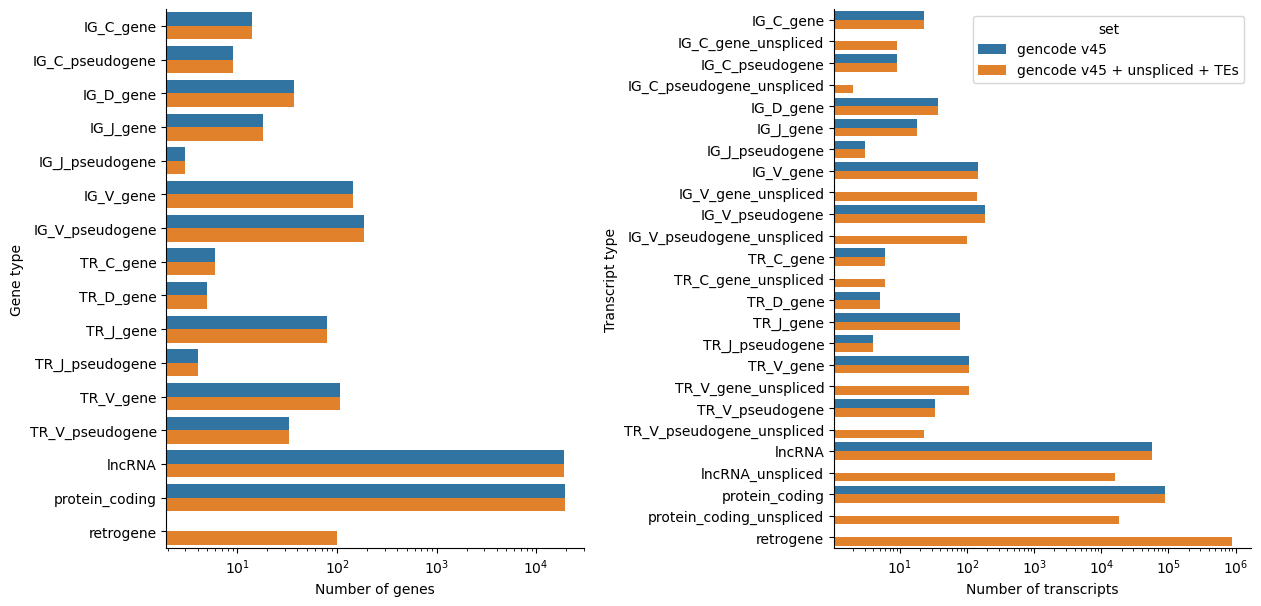

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# add wspace
fig.subplots_adjust(wspace=0.6)

df = (
    gtf[["gene_id", "gene_type", "set"]]
    .drop_duplicates()
    .groupby(["gene_type", "set"])
    .size()
    .reset_index(name="count")
)

sns.barplot(y="gene_type", x="count", hue="set", data=df, ax=ax1)
ax1.set_xscale("log")
ax1.set_xlabel("Number of genes")
ax1.set_ylabel("Gene type")
# remove legend
ax1.legend_.remove()


df = (
    gtf[["transcript_id", "transcript_type", "set"]]
    .drop_duplicates()
    .groupby(["transcript_type", "set"])
    .size()
    .reset_index(name="count")
)

sns.barplot(y="transcript_type", x="count", hue="set", data=df, ax=ax2)
ax2.set_xscale("log")
ax2.set_xlabel("Number of transcripts")
ax2.set_ylabel("Transcript type")

sns.despine()